# **Project: Advanced Lane Lines**

**The steps of the project are the following:**

TODO: make sure this list matches the actual steps

1. Calibrate the camera.
2. Undistort images.
3. Use a combination of color space transforms, gradients and thresholding to create a binary image.
4. Apply perspective transform to get the "birds-eye" view
5. Detect the lane lines, and fit polynomials to them
6. Determine the lane curvature and vehicle position wrt. the center
7. Build the pipeline
8. Output video and numerical estimation of the curvature

## **Imports**

In [42]:
import cv2
import numpy as np
import glob
import pickle
import matplotlib.pyplot as plt
import os
%matplotlib inline


## **Helper Functions**

In [43]:
def show_imgs_side_by_side(img1, img2, title_1 = 'Image 1', title_2 = 'Image_2', cmap1 = None, cmap2 = None):
    fig, (axs1, axs2) = plt.subplots(1, 2, figsize = (20, 20))
    
    fig.subplots_adjust(hspace = 0.2, wspace = 0.4)
    
    axs1.imshow(img1, cmap = cmap1)
    axs1.set_title(title_1, fontsize = 25)
    
    axs2.imshow(img2, cmap = cmap2)
    axs2.set_title(title_2, fontsize = 25)
    
    return (axs1, axs2)

def show_src(axs, src):
    src_x = [src[0][0], src[2][0], src[3][0], src[1][0], src[0][0]]
    src_y = [src[0][1], src[2][1], src[3][1], src[1][1], src[0][1]]
    
    axs.plot(src_x, src_y, color = 'tab:red')


    
    
    
    

## **Pipeline Functions**

In [110]:
# Applies the perspective transform
# Set method = 'inv' to apply the inverse transform
def warp(img, src, dst, method = ''):    
    n_rows, n_cols = img.shape[:2]
    
    if method == 'inv':
        pts1 = dst
        pts2 = src
    else:
        pts1 = src
        pts2 = dst

    M = cv2.getPerspectiveTransform(pts1, pts2) 
    
    warped = cv2.warpPerspective(img, M , (n_cols, n_rows), borderMode = cv2.BORDER_REPLICATE)

    return warped

# Applies sobel in x OR y, then takes the absolute value and applies a threshold
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

    sobel_abs = np.absolute(sobel)
   

    scaled_sobel = np.uint8(255*sobel_abs/np.max(sobel_abs))
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return binary_output

def dir_threshold(img, sobel_kernel = 3, thresh=(0, np.pi/2)):

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)

    sobelx_abs = np.absolute(sobelx)
    sobely_abs = np.absolute(sobely)
    
    grad_dir = np.arctan2(sobely_abs, sobelx_abs)
    
    binary_output = np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    
    return binary_output

#def combine_binary_output(binary_output_1, binary_output_2):
#    combined_binary_output = np.zeros_like(binary_output_1)
#    combined_binary_output[((binary_output_1 == 1) & (binary_output_2 == 1))] = 1
#    return combined_binary_output

def combine_binary_outputs(binary_outputs):
    combined_binary_output = np.zeros_like(binary_outputs[0])
    combined_binary_output[((binary_outputs[0] == 1) & (binary_outputs[1] == 1))] = 1
    if (len(binary_outputs) > 2):
        for i in range(2, len(binary_outputs)):
            combined_binary_output[((combined_binary_output == 1) & (binary_outputs[i] == 1))] = 1
    return combined_binary_output
            
    
    

## **Step 1: Calibrate the Camera**

**Please Note:** [This link](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_calib3d/py_calibration/py_calibration.html) was incredibly useful for this step, and I used pretty much the same approach as the camera calibration example.  

No corners found for image: calibration01.jpg
No corners found for image: calibration04.jpg
No corners found for image: calibration05.jpg


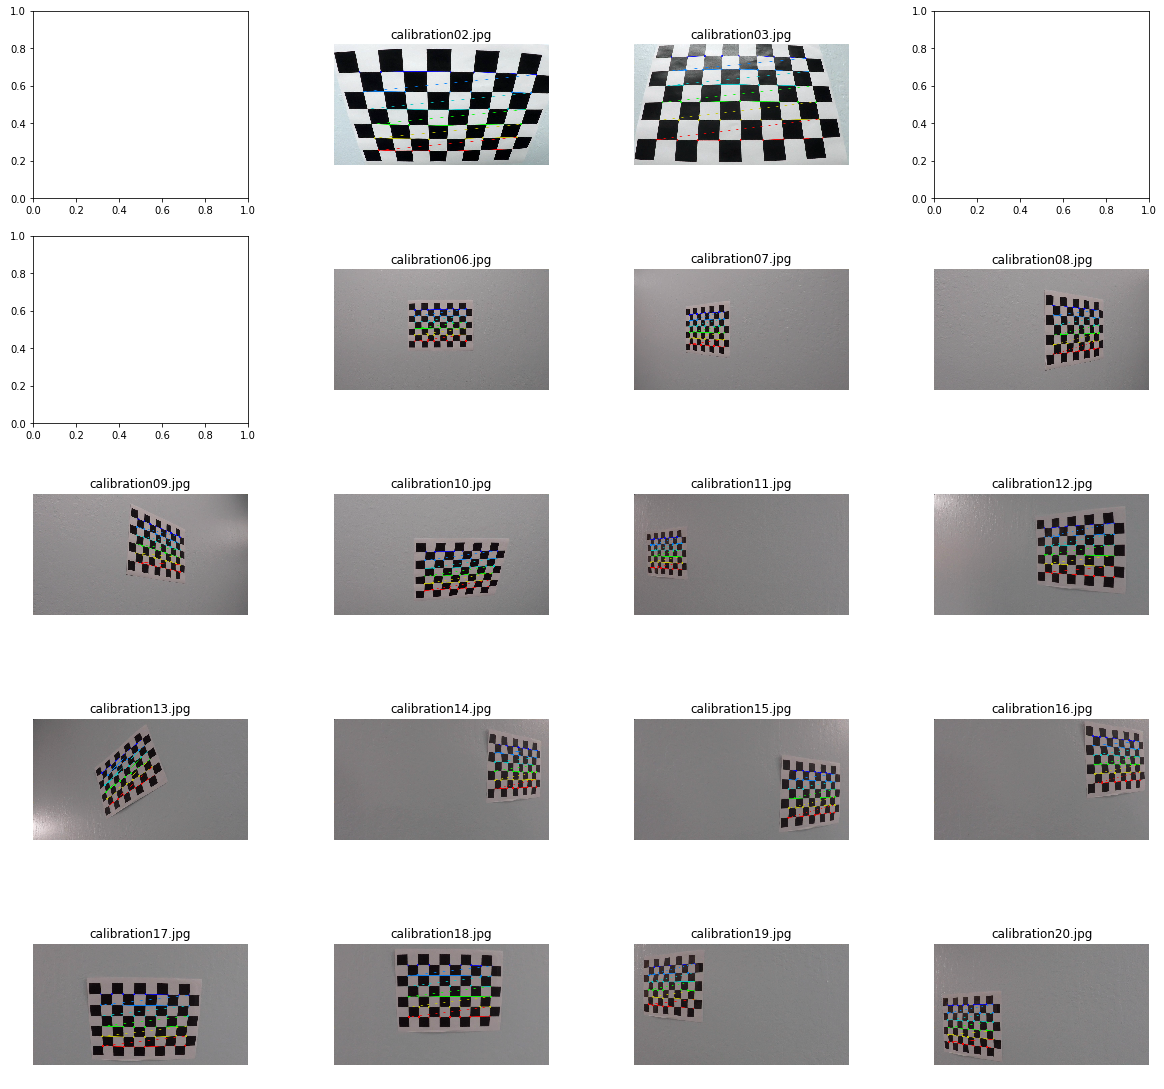

In [45]:


calib_imgs = sorted(glob.glob('./camera_cal/calibration*.jpg'))

nx = 6 # Corners in the x-dir
ny = 9 # Corners in the y-dir


# Criteria for the termination of the iterative process of corner refinement
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# These are the 3D points (Y,Y,Z) (world points), and we assume Z = 0
# i.e the chessboard was only moved in the XY plane. This is a
# simplifying assumtion. 
obj_points_for_img = np.zeros((ny * nx, 3), np.float32)

# Generate a mesh-grid so that we get the points
# (0, 0, 0), (1, 0, 0), (2, 0, 0), ..... (ny - 1, 0, 0)
# (0, 1, 0), (1, 1, 0), (2, 1, 0), ......(ny - 1, 1, 0)
# ... all the way to ...
# (0, nx - 1, 0), (1, nx - 1, 0), ...... (ny - 1, nx - 1, 0)
obj_points_for_img[:, : 2] = np.mgrid[0 : ny, 0 : nx].T.reshape(-1, 2)


# Store 3D world points for all images
obj_points = []

# Store 2D image plane points for all images
img_points = []


fig, axs = plt.subplots(5, 4, figsize = (20, 20))
fig.subplots_adjust(hspace = 0.2, wspace = 0.4)
axs = axs.reshape(-1)

for i in range(len(calib_imgs)):
    
    img = cv2.imread(calib_imgs[i])
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (ny , nx), None)
    
    # Check if we have found any corners
    if ret == True:
        # Add object points to the image
        obj_points.append(obj_points_for_img)
        
        # Refine the corners and add them
        refined_corners = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        img_points.append(refined_corners)
        
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (ny, nx), refined_corners, ret)
        axs[i].axis('off')
        axs[i].imshow(img)
        axs[i].set_title(os.path.basename(calib_imgs[i]))
    else:
        print("No corners found for image: " + os.path.basename(calib_imgs[i]))
        
        
        
        


In [46]:
# Do the actual camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)

## **Step 2: Undistort Images**
Lets test our camera calibration


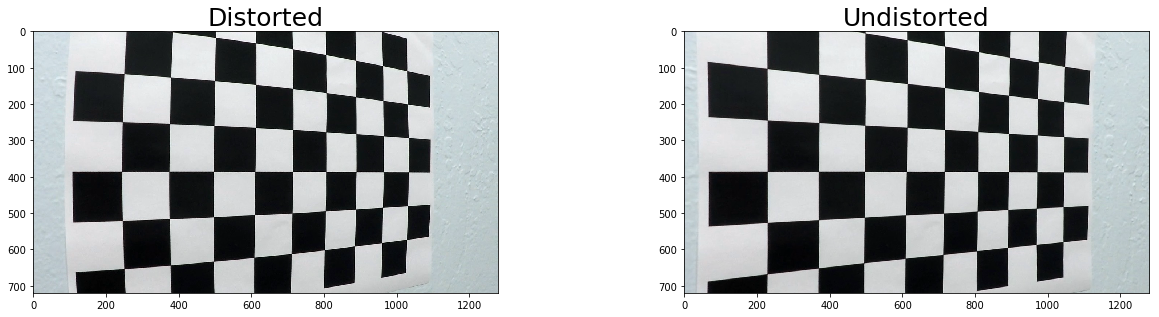

In [52]:
# Read in some test images
test_imgs = glob.glob('./test_images/*.jpg')

# Test undistortion on a checkerboard image
dst = cv2.imread(calib_imgs[4]) # calibration05.jpg looks distorted
undist = cv2.undistort(dst, mtx, dist, None, mtx)
(_, _) = show_imgs_side_by_side(dst, undist, "Distorted", "Undistorted")



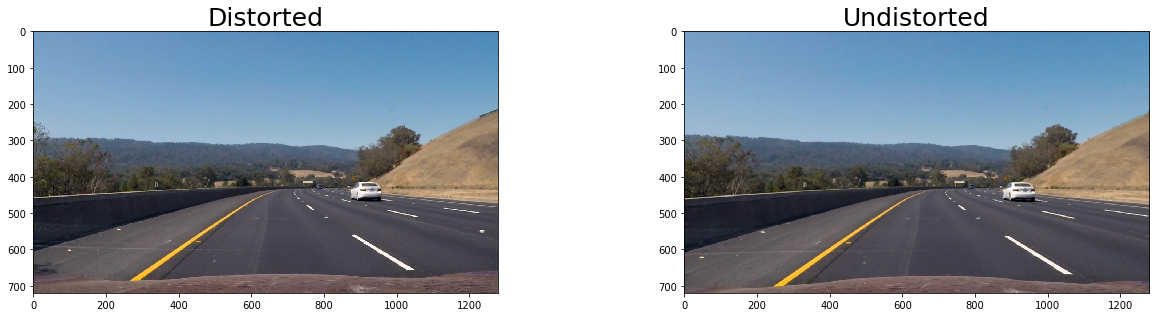

In [53]:
# Test undistortion on a test image
dst = plt.imread(test_imgs[7]) # test3.jpg looks like a good test image
undist = cv2.undistort(dst, mtx, dist, None, mtx)
(_, _) = show_imgs_side_by_side(dst, undist, "Distorted", "Undistorted")

For the checkerboard image, the undistortion is noticable, and seems to work right. 
For the test image, the undistortion is most noticable when looking at the hood of the car. 

## **Step 3: Get the birds-eye view**

Lets test our warp function on the undistorted test image

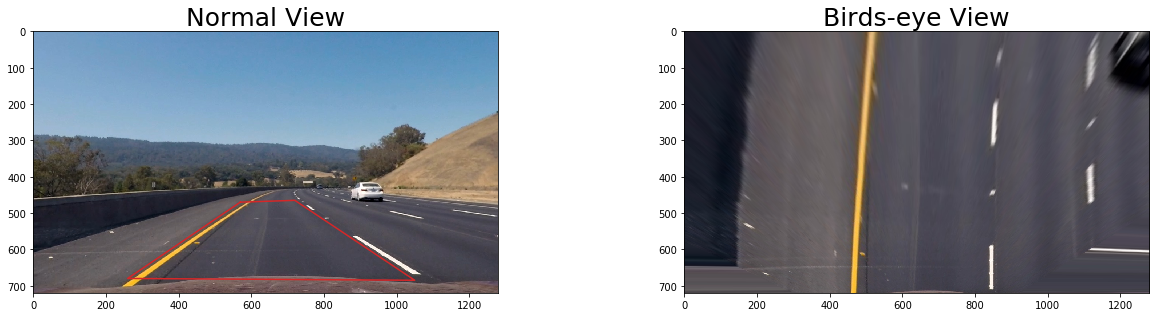

In [39]:
n_rows, n_cols = undist.shape[:2]


src = np.float32([(570, 470), (720, 465), (260, 680), (1050, 685)])
dst = np.float32([(450, 0), (n_cols - 450, 0), (450, n_rows), (n_cols - 450, n_rows)])




warped = warp(undist, src, dst)
axs1, axs2 = show_imgs_side_by_side(undist, warped, "Normal View","Birds-eye View")
show_src(axs1, src)

## **Step 4: Test the gradient thresholding**

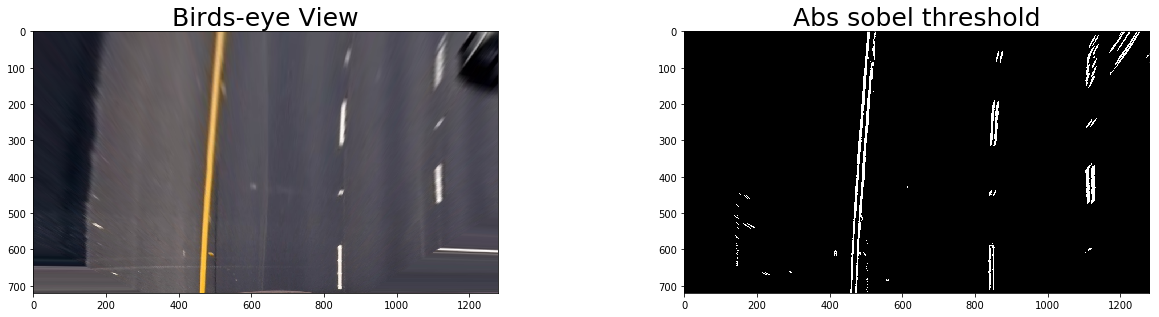

In [83]:
abs_sobel_warped = abs_sobel_thresh(warped, orient = 'x', thresh_min = 25, thresh_max = 255)
(_, _) = show_imgs_side_by_side(warped, abs_sobel_warped, "Birds-eye View",\
                                "Abs sobel threshold", cmap1 = None, cmap2= 'gray')

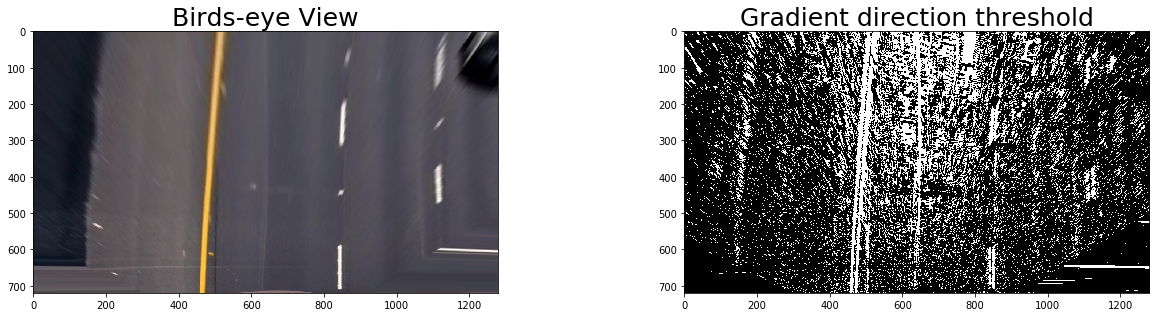

In [100]:
dir_threshold_warped = dir_threshold(warped, sobel_kernel = 7, thresh=(0, 0.2))
(_, _) = show_imgs_side_by_side(warped, dir_threshold_warped, "Birds-eye View",\
                                "Gradient direction threshold", cmap1 = None, cmap2= 'gray')

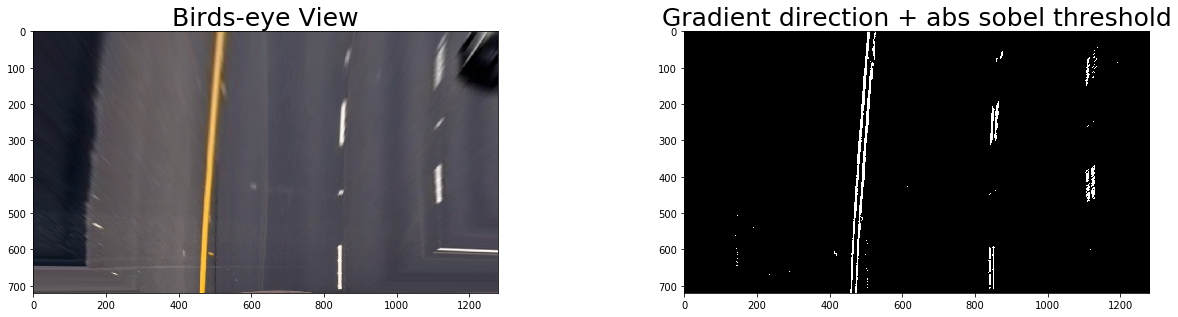

In [111]:
combined = combine_binary_outputs([abs_sobel_warped, dir_threshold_warped])
(_, _) = show_imgs_side_by_side(warped, combined, "Birds-eye View",\
                                "Gradient direction + abs sobel threshold", cmap1 = None, cmap2= 'gray')

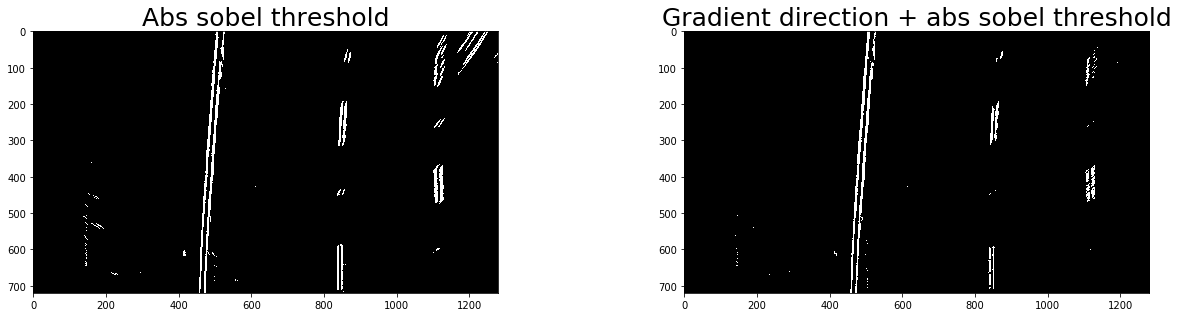

In [112]:
(_, _) = show_imgs_side_by_side(abs_sobel_warped, combined, "Abs sobel threshold",\
                                "Gradient direction + abs sobel threshold", cmap1 = 'gray', cmap2= 'gray')

I'm not sure if I see any need to include the gradient driection based on this.

## **Step 5: Test the color thresholding**

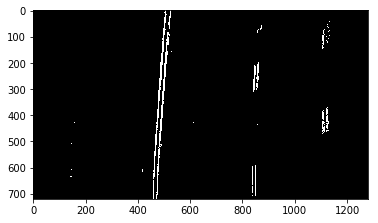